# Load the model

In [1]:
from model.build import build_model


config_file = './model/config.yml'
test_config_file = './model/demo_batch_config.yml'
model, _ = build_model(config_file, test_config_file)

{'BBOX_NMS_OVERLAP': 0.3,
 'DETECTION_SCORE_THRESH': 0.5,
 'IMG_DO_CLIP': True,
 'MASK_THRESHOLD': 0.5,
 'MAX_DETECTIONS_PER_IMG': 15,
 'MIN_LYMPH_NODE_DIAM_TO_SHOW': 0,
 'RESULT_FIELDS': ['tag_scores', 'scores', 'contour_mm'],
 'TAGS_TO_KEEP': {},
 'TEST_SLICE_INTV_MM': 1}
Using 1 GPUs
lesion tags loaded from ./model/program_data/tags_cache.json
171 tags, 20266 lesions with tags, 81430 positive tags altogether
252 parent-children relation pairs; 4451 exclusive relation pairs
DeepLesion train num_images: 22478
building model ...
Loading checkpoint from ./model/checkpoints/MULAN trained on DeepLesion_epoch_08.pth
optimizer and scheduler not loaded from checkpoint file


# Extract model's predictions

In [3]:
import os
import matplotlib.pyplot as plt
from interpretability.metrics import visualize_consistency
from model.maskrcnn.engine.demo_process import exec_model, get_windows_inds
from model.data.utils import normalize_image, draw_pred_bboxes


In [13]:
data_dir = './data'
anno_file_path = './model/data/DeepLesion/DL_info.csv'

img_path = ['000114_02_01_204-281.nii.gz']
window_inds =  get_windows_inds(anno_file_path, img_path)

In [14]:
predictions = []
images = []

for img_path_, win_ind in zip(img_path, window_inds):
    prediction, image = exec_model(model, os.path.join(data_dir, img_path_), win_ind)
    predictions.append(prediction)
    images.append(image)

reading image ...
predicting ...
slices_to_process range(0, 78)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:29<00:00,  2.61it/s]

result images and text saved to ./model/results/._data_000114_02_01_204-281.nii.gz
processing time: 179 ms per slice


In [15]:
sample = images[0][:4]

In [16]:
sample_bboxes = [pred['bboxes'] for pred in predictions[0][:4]]
sample_scores = [pred['scores'] for pred in predictions[0][:4]]

# Generate explanations 

For this experiment, we have chosen only Layer Gradient SHAP algorithm to demonstrate interpretations of the features extracted for object detection from a backbone and a Region Proposal Network of the model. Explanations for features with and without fusion have been visualized as well. 

In [7]:
import torch
from interpretability.explainers import Explainer 
from captum._utils.models.linear_model import SkLearnLinearRegression
from interpretability.interpretable_models import DecisionTree, train_tree

In [8]:
explainer = Explainer()

explanation_method = 'LayerGradientShap'
target = torch.tensor([1], device=torch.device('cuda:0'))

In [9]:
def rpn_forward_fused(input):
    features = model.backbone(input)
    features, images = model.feature_fuse(features, input)
    proposals = model.rpn.head(features)
    cls_logits, bbox_reg = proposals
    output = cls_logits[0].sum(dim=(2, 3))
    return output

In [10]:
def rpn_forward(input):
    features = model.backbone(input)
    proposals = model.rpn.head(features)
    cls_logits, bbox_reg = proposals
    output = cls_logits[0].sum(dim=(2, 3))
    return output

In [11]:
def forward_fused(input):
    output = model.backbone(input)
    features, image = model.feature_fuse(output, input)
    features = features[0].sum(dim=(2, 3))
    return features


In [12]:
def forward_fn(input):
    features = model.backbone(input)
    features = features[0].sum(dim=(2, 3))
    return features


In [27]:
sample_attributes = {}

sample_attributes['rpn_fused'] = explainer.get_explanations(explanation_method, 
                                                                                sample, 
                                                                                rpn_forward_fused,
                                                                                model=model,
                                                                                target=target)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


In [28]:
sample_attributes['rpn'] = explainer.get_explanations(explanation_method, 
                                                                          sample, 
                                                                          rpn_forward,
                                                                          model=model,
                                                                          target=target)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


In [29]:
sample_attributes['backbone_fused'] = explainer.get_explanations(explanation_method, 
                                                                                sample, 
                                                                                forward_fused,
                                                                                model=model,
                                                                                target=target)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.77it/s]


In [30]:
sample_attributes['backbone_fn'] = explainer.get_explanations(explanation_method, 
                                                                                sample, 
                                                                                forward_fn,
                                                                                model=model,
                                                                                target=target)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


In [37]:
attributes = [sample, *list(sample_attributes.values())]
methods = ['original image', *list(sample_attributes.keys())]

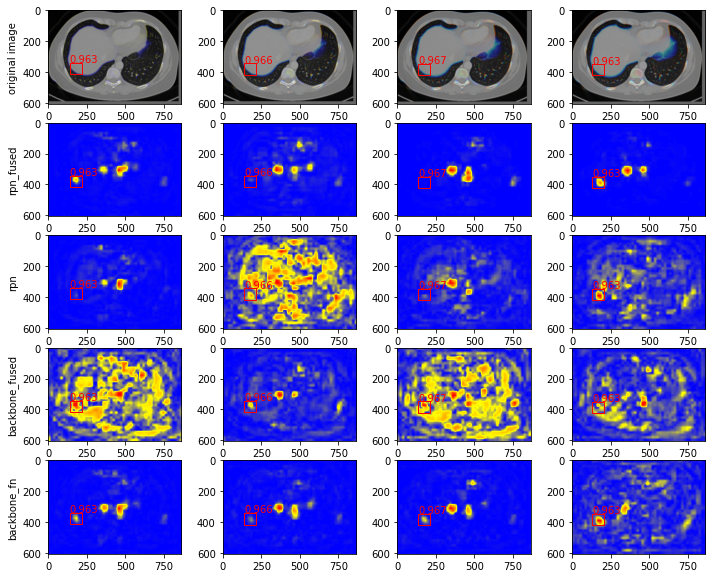

In [39]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('blue', 
                                                 [(0, '#0000ff'),
                                                  (0.25, '#ffff00'),
                                                  (1, '#ff0000')], N=256) 

visualize_consistency(attributes, methods, sample_bboxes, sample_scores, cmap, save_fig=True, 
                     file_path='/home/jovyan/work/XAI/models/mulan/explanation_results/rpn_backbone_comparison.png')